In [23]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.calculate_proximity import plot_average_importance
from functions.calculate_monthly_returns import calculate_monthly_returns
from functions.load_datasets import load_datasets
from functions.load_datasets import organize_financial_data_by_year
from functions.load_datasets import sort_columns_chronologically
from functions.create_monthly_feature_data import create_monthly_feature_data
from functions.calculate_ml_signal import calculate_ml_signal
from functions.fetch_topix_returns import fetch_topix_returns

pd.set_option('future.no_silent_downcasting', True)

In [7]:
base = str(project_root) + "/data/"

config = {
    "df_sales": ("sales.xls", 1),
    "df_capital": ("capital.xls", 1),
    "df_cogs_ratio": ("cost.xls", 1),
    "df_sga_ratio": ("cost.xls", 2),
    "df_roic": ("roic.xls", 1),
    "df_rd_ratio": ("rd_profit.xls", 1),
    "df_opm": ("rd_profit.xls", 2),
    "df_roe": ("roe.xls", 1),
    "df_interest": ("interest_expenses.xls", 1),
}

dfs = {
    name: pd.read_excel(base + file, sheet_name=sheet).rename(columns={"Unnamed: 0": "Company"})
    for name, (file, sheet) in config.items()
}

years = list(range(2025, 2019, -1))
financial_dfs = organize_financial_data_by_year(dfs, years)
df_industry = pd.read_excel(base + "nikkei_industry.xls", sheet_name=1).dropna().rename(columns={"Unnamed: 0": "Company"}).set_index("Company").drop_duplicates()
df_industry = df_industry[~df_industry.index.duplicated(keep='first')].dropna()
rf_df = pd.read_csv(base + "rf.csv", header=None).iloc[:, [0,2]].rename(columns={0: "date", 2: "rf"}).set_index("date")

In [8]:
df_pbr, df_stp, df_mktcap = load_datasets(base)
df_returns = calculate_monthly_returns(df_stp)

In [9]:
monthly_feature_data = create_monthly_feature_data(financial_dfs, df_pbr, df_industry)

print(f"月次特徴量データの作成完了")
print(f"利用可能な月数: {len(monthly_feature_data)}")

# データ構造の確認
available_months = sorted(monthly_feature_data.keys())
if len(available_months) > 0:
    print(f"\n最初の月: {available_months[0]}")
    print(f"最後の月: {available_months[-1]}")
    print(f"\n例 (2021/01): 形状 = {monthly_feature_data.get('2021/01', pd.DataFrame()).shape if '2021/01' in monthly_feature_data else 'なし'}")
    if '2021/01' in monthly_feature_data:
        print(f"  → 使用財務データ: 2020年度 (2020/06から利用可能)")
    print(f"\n例 (2021/06): 形状 = {monthly_feature_data.get('2021/06', pd.DataFrame()).shape if '2021/06' in monthly_feature_data else 'なし'}")
    if '2021/06' in monthly_feature_data:
        print(f"  → 使用財務データ: 2021年度 (2021/06から利用可能)")

月次特徴量データの作成完了
利用可能な月数: 67

最初の月: 2020/06
最後の月: 2025/12

例 (2021/01): 形状 = (4007, 12)
  → 使用財務データ: 2020年度 (2020/06から利用可能)

例 (2021/06): 形状 = (4007, 12)
  → 使用財務データ: 2021年度 (2021/06から利用可能)


使用する特徴量: ['sales', 'capital', 'cogs_ratio', 'sga_ratio', 'roic', 'rd_ratio', 'opm', 'roe', 'interest', 'industry', 'profitability_a', 'log_pbr']
'industry' in 特徴量: True
ML戦略（類似企業ベース相対PBR）の実行
★ 改善: PBRがある企業だけで類似度を計算
corr: 0.9619, rmse: 0.2901
corr: 0.9601, rmse: 0.3127
corr: 0.9611, rmse: 0.3219
corr: 0.9633, rmse: 0.2924
corr: 0.9526, rmse: 0.3302
corr: 0.9494, rmse: 0.3340
corr: 0.9541, rmse: 0.3174
corr: 0.9483, rmse: 0.3259
corr: 0.9500, rmse: 0.3290
corr: 0.9470, rmse: 0.3304
corr: 0.9430, rmse: 0.3311
corr: 0.8219, rmse: 0.5756
corr: 0.8765, rmse: 0.4726
corr: 0.8975, rmse: 0.4390
corr: 0.9163, rmse: 0.3985
corr: 0.9200, rmse: 0.3926
corr: 0.9240, rmse: 0.3910
corr: 0.9298, rmse: 0.3594
corr: 0.9306, rmse: 0.3582
corr: 0.9345, rmse: 0.3417
corr: 0.9418, rmse: 0.3196
corr: 0.9445, rmse: 0.3157
corr: 0.9351, rmse: 0.3400
corr: 0.8193, rmse: 0.5412
corr: 0.8819, rmse: 0.4409
corr: 0.9029, rmse: 0.3982
corr: 0.9194, rmse: 0.3716
corr: 0.9316, rmse: 0.3473
corr: 0.9345, rmse: 0.3368
co

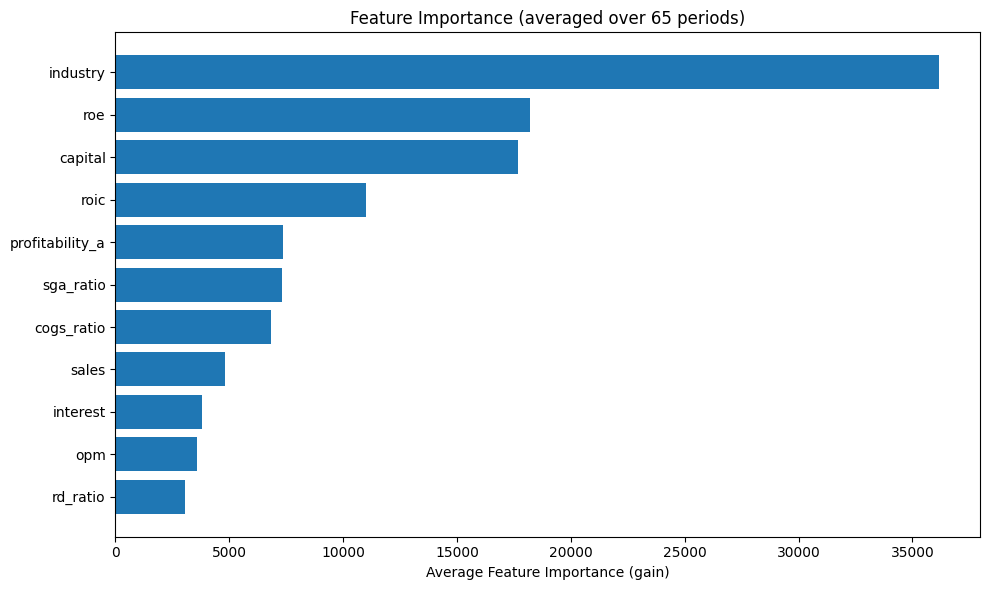

In [10]:
# 使用する特徴量の確認
sample_month = list(monthly_feature_data.keys())[0]
has_industry = 'industry' in monthly_feature_data[sample_month].columns
print(f"使用する特徴量: {list(monthly_feature_data[sample_month].columns)}")
print(f"'industry' in 特徴量: {has_industry}")

debug_filename = 'debug_with_industry.pkl' if has_industry else 'debug_without_industry.pkl'

print("=" * 80)
print("ML戦略（類似企業ベース相対PBR）の実行")
print("★ 改善: PBRがある企業だけで類似度を計算")
print("=" * 80)

quintile_returns_ml, importance_list = calculate_ml_signal(
    monthly_feature_data=monthly_feature_data,
    df_pbr_sorted=df_pbr,
    df_returns=df_returns,
    n_quintiles=5,
    lookback_months=12,
    top_k=10,
    save_debug_file=debug_filename
)

print("\n" + "=" * 80)
print("特徴量重要度（全期間平均）")
print("=" * 80)
avg_importance = plot_average_importance(importance_list)

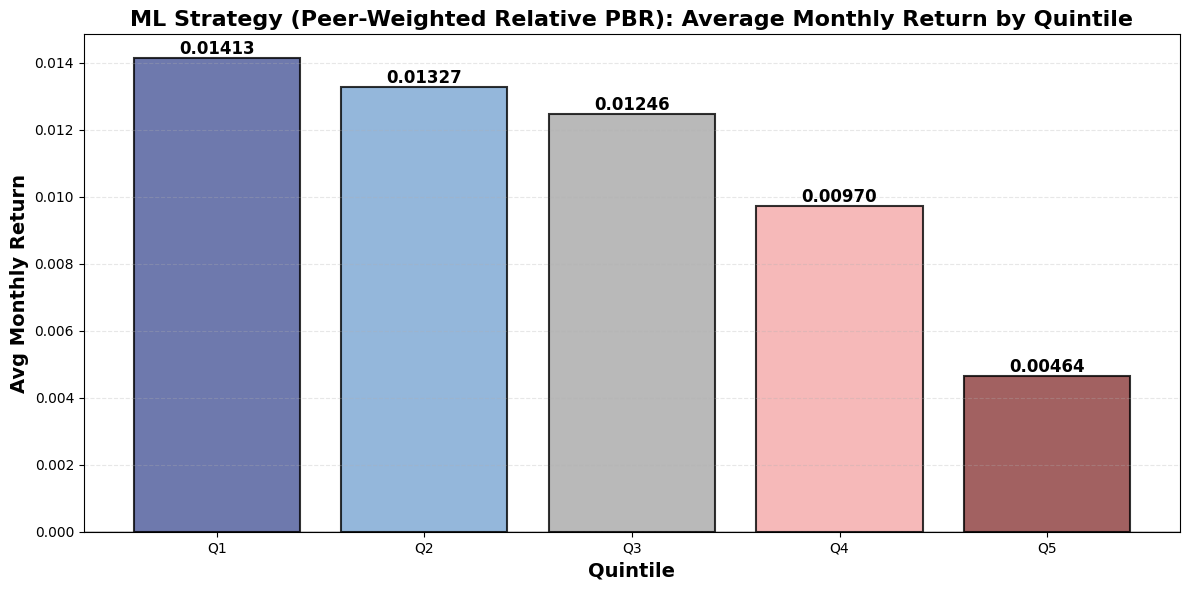


各分位の平均月次リターン（ML戦略）:
Q1: 0.01413 (1.413%)
Q2: 0.01327 (1.327%)
Q3: 0.01246 (1.246%)
Q4: 0.00970 (0.970%)
Q5: 0.00464 (0.464%)


In [11]:
# 図1: ML戦略 - 平均月次リターンのヒストグラム
plt.figure(figsize=(12, 6))

mean_returns_ml = quintile_returns_ml.mean()
colors = ['#4A5899', '#7AA5D2', '#A8A8A8', '#F4A8A8', '#8B3A3A']

bars = plt.bar(mean_returns_ml.index, mean_returns_ml.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Quintile', fontsize=14, fontweight='bold')
plt.ylabel('Avg Monthly Return', fontsize=14, fontweight='bold')
plt.title('ML Strategy (Peer-Weighted Relative PBR): Average Monthly Return by Quintile',
          fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.5f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n各分位の平均月次リターン（ML戦略）:")
for q, ret in mean_returns_ml.items():
    print(f"{q}: {ret:.5f} ({ret*100:.3f}%)")

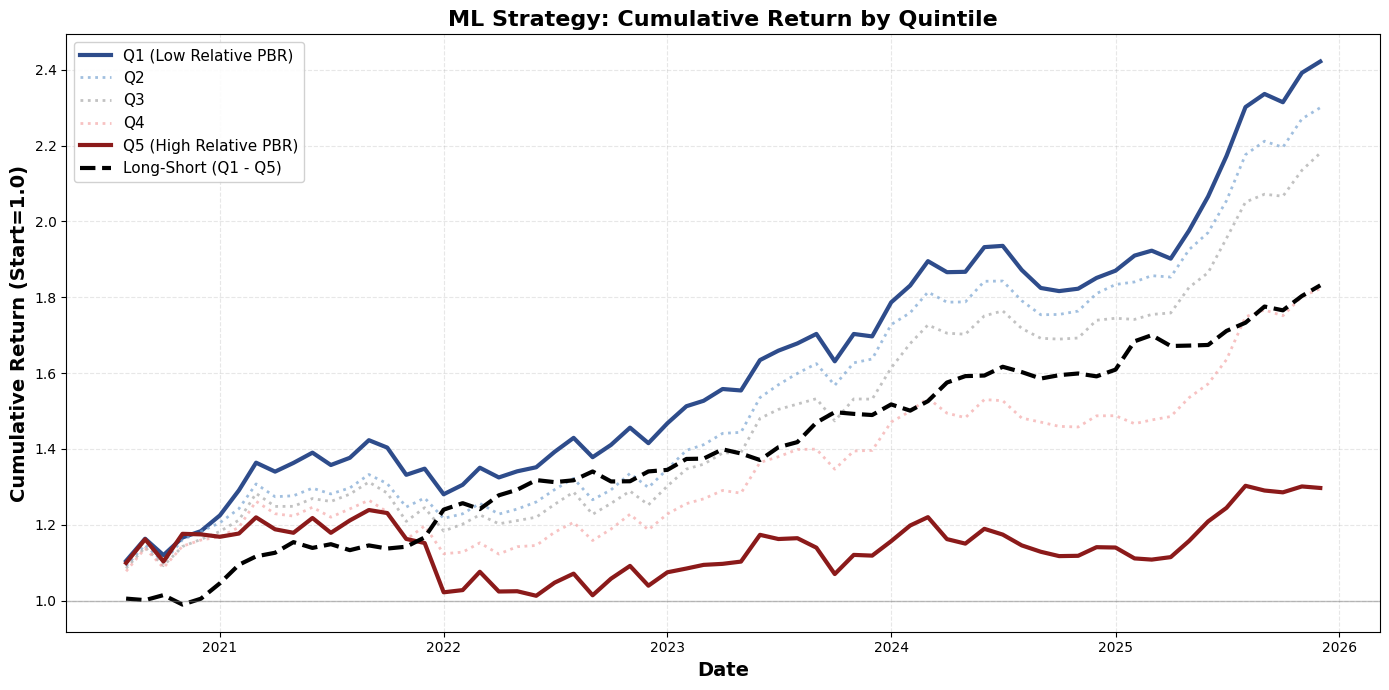


最終累積リターン（ML戦略、開始=1.0）:
Q1: 2.4215 (累積リターン: +142.15%)
Q2: 2.2999 (累積リターン: +129.99%)
Q3: 2.1803 (累積リターン: +118.03%)
Q4: 1.8226 (累積リターン: +82.26%)
Q5: 1.2972 (累積リターン: +29.72%)
Long-Short (Q1-Q5): 1.8314 (累積リターン: +83.14%)


In [12]:
# 図2: ML戦略 - 累積リターンの推移
plt.figure(figsize=(14, 7))

# 累積リターンを計算
cumulative_returns_ml = (1 + quintile_returns_ml).cumprod()

# Long-Short ポートフォリオ
long_short_returns_ml = quintile_returns_ml['Q1'] - quintile_returns_ml['Q5']
cumulative_long_short_ml = (1 + long_short_returns_ml).cumprod()

# 日付インデックス
dates = pd.to_datetime(cumulative_returns_ml.index, format='%Y/%m')

# プロット
plt.plot(dates, cumulative_returns_ml['Q1'], linewidth=3, color='#2E4C8B',
         label='Q1 (Low Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_returns_ml['Q2'], linewidth=2, color='#7AA5D2',
         label='Q2', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q3'], linewidth=2, color='#A8A8A8',
         label='Q3', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q4'], linewidth=2, color='#F4A8A8',
         label='Q4', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_ml['Q5'], linewidth=3, color='#8B1A1A',
         label='Q5 (High Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_long_short_ml, linewidth=3, color='black',
         label='Long-Short (Q1 - Q5)', linestyle='--')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Return (Start=1.0)', fontsize=14, fontweight='bold')
plt.title('ML Strategy: Cumulative Return by Quintile', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターン
print("\n最終累積リターン（ML戦略、開始=1.0）:")
for col in cumulative_returns_ml.columns:
    final_return = cumulative_returns_ml[col].iloc[-1]
    total_return_pct = (final_return - 1) * 100
    print(f"{col}: {final_return:.4f} (累積リターン: {total_return_pct:+.2f}%)")

final_ls_ml = cumulative_long_short_ml.iloc[-1]
total_ls_pct_ml = (final_ls_ml - 1) * 100
print(f"Long-Short (Q1-Q5): {final_ls_ml:.4f} (累積リターン: {total_ls_pct_ml:+.2f}%)")

In [13]:
# ML戦略のバリュープレミアム統計分析
value_premium_ml = quintile_returns_ml['Q1'] - quintile_returns_ml['Q5']

print("\n" + "=" * 80)
print("ML戦略のバリュープレミアム（Q1 - Q5）の統計分析")
print("=" * 80)
print(f"平均月次プレミアム: {value_premium_ml.mean():.5f} ({value_premium_ml.mean()*100:.3f}%)")
print(f"標準偏差: {value_premium_ml.std():.5f}")
print(f"t値: {value_premium_ml.mean() / (value_premium_ml.std() / np.sqrt(len(value_premium_ml))):.4f}")

# t検定
t_stat_ml, p_value_ml = stats.ttest_1samp(value_premium_ml.dropna(), 0)
print(f"p値: {p_value_ml:.6f}")

if p_value_ml < 0.01:
    sig_ml = '***'
elif p_value_ml < 0.05:
    sig_ml = '**'
elif p_value_ml < 0.1:
    sig_ml = '*'
else:
    sig_ml = ''

print(f"有意性: {sig_ml} ({'有意' if sig_ml else '有意でない'})")
print(f"\n勝率（プレミアムが正の月）: {(value_premium_ml > 0).sum() / len(value_premium_ml) * 100:.2f}%")
print("=" * 80)


ML戦略のバリュープレミアム（Q1 - Q5）の統計分析
平均月次プレミアム: 0.00949 (0.949%)
標準偏差: 0.01694
t値: 4.7199
p値: 0.000028
有意性: *** (有意)

勝率（プレミアムが正の月）: 66.20%


In [14]:
# シャープレシオの計算（リスクフリーレートを考慮）
print("\n" + "=" * 80)
print("シャープレシオの計算（リスクフリーレートを考慮）")
print("=" * 80)

# リスクフリーレート
rf_monthly = rf_df['rf'] / 100

# 各分位のシャープレシオ
sharpe_ratios_ml = {}
for col in quintile_returns_ml.columns:
    # 各月のリターンからリスクフリーレートを引いて超過リターンを計算
    excess_returns = quintile_returns_ml[col].copy()
    for idx in excess_returns.index:
        if idx in rf_monthly.index:
            excess_returns[idx] = excess_returns[idx] - rf_monthly[idx]

    mean_excess = excess_returns.mean()
    std_return = excess_returns.std()
    sharpe_monthly = mean_excess / std_return if std_return > 0 else 0
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    sharpe_ratios_ml[col] = {
        '月次': sharpe_monthly,
        '年率換算': sharpe_annual
    }

# Long-Short戦略（既に差分なのでリスクフリーレートは相殺される）
ls_ml_mean = value_premium_ml.mean()
ls_ml_std = value_premium_ml.std()
ls_ml_sharpe_monthly = ls_ml_mean / ls_ml_std if ls_ml_std > 0 else 0
ls_ml_sharpe_annual = ls_ml_sharpe_monthly * np.sqrt(12)

sharpe_ratios_ml['Long-Short (Q1-Q5)'] = {
    '月次': ls_ml_sharpe_monthly,
    '年率換算': ls_ml_sharpe_annual
}

sharpe_df_ml = pd.DataFrame(sharpe_ratios_ml).T
print("\nシャープレシオ:")
print(sharpe_df_ml.to_string())

print("\n" + "=" * 80)
print("解釈:")
print("-" * 80)
print("- シャープレシオ = (平均リターン - リスクフリーレート) / リターンの標準偏差")
print("- リスク調整後のパフォーマンスを測定")
print("- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる")
print("- 年率換算 = 月次シャープレシオ × sqrt(12)")
print("- Long-Shortはロング・ショート両方からRfを引くため相殺される")
print("=" * 80)


シャープレシオの計算（リスクフリーレートを考慮）

シャープレシオ:
                          月次      年率換算
Q1                  0.443571  1.536575
Q2                  0.444033  1.538176
Q3                  0.408439  1.414874
Q4                  0.299122  1.036190
Q5                  0.104938  0.363515
Long-Short (Q1-Q5)  0.560148  1.940409

解釈:
--------------------------------------------------------------------------------
- シャープレシオ = (平均リターン - リスクフリーレート) / リターンの標準偏差
- リスク調整後のパフォーマンスを測定
- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる
- 年率換算 = 月次シャープレシオ × sqrt(12)
- Long-Shortはロング・ショート両方からRfを引くため相殺される


In [15]:
# ===================================================================
# Fama-French 3ファクターモデルによるアルファ検証
# ===================================================================

print("時価総額データの形状:", df_mktcap.shape)
print("\n時価総額データの最初の数行:")
print(df_mktcap.head())

# 列名のマッピング（P → 2025, P-1 → 2024, ...）
# P, P-1, P-2, ... の形式を YYYY/MM に変換
def map_mktcap_columns(df_mktcap):
    """
    時価総額データの列名を年/月形式に変換
    P → 2025, P-1 → 2024, P-2 → 2023, ...
    """
    new_columns = {'Company': 'Company'}

    for col in df_mktcap.columns:
        if col == 'Company':
            continue

        if col == 'P':
            # P → 2025年（決算月を12月と仮定）
            new_columns[col] = '2025/12'
        elif col.startswith('P-'):
            # P-1 → 2024, P-2 → 2023, ...
            offset = int(col.split('-')[1])
            year = 2025 - offset
            new_columns[col] = f'{year}/12'

    df_renamed = df_mktcap.rename(columns=new_columns)
    return df_renamed

df_mktcap_renamed = map_mktcap_columns(df_mktcap)

print("\n列名マッピング後:")
print(df_mktcap_renamed.columns.tolist()[:10])

時価総額データの形状: (4103, 22)

時価総額データの最初の数行:
          Company             P           P-1           P-2           P-3  \
0     あい　ホールディングス  146023190000  1.481009e+11  1.427736e+11  1.492730e+11   
1  あいちフィナンシャルグループ  221001040000  2.263616e+11  1.937119e+11  1.522892e+11   
2          あおぞら銀行  330730920000  3.341904e+11  3.051995e+11  3.203522e+11   
3          あかつき本社   16859880000  1.713170e+10  1.619341e+10  1.658689e+10   
4       あさかわシステムズ    1316340000  1.316340e+09  1.316340e+09  1.316340e+09   

            P-4           P-5           P-6           P-7           P-8  ...  \
0  1.373930e+11  1.289765e+11  1.249277e+11  1.226369e+11  1.125690e+11  ...   
1  1.426889e+11  1.324761e+11  1.235860e+11  1.259233e+11  1.335867e+11  ...   
2  3.170311e+11  3.068601e+11  2.991799e+11  2.900468e+11  2.719188e+11  ...   
3  1.688957e+10  1.607234e+10  1.525510e+10  1.501295e+10  1.474057e+10  ...   
4  1.316340e+09  1.316340e+09  1.316340e+09  1.316340e+09  1.316340e+09  ...   

           P-11  

In [16]:
# 時系列順に並び替え
df_mktcap_sorted = sort_columns_chronologically(df_mktcap_renamed)

print("時価総額データを時系列順に並び替え完了")
print(f"列の例: {df_mktcap_sorted.columns.tolist()[1:11]}")

# Carhart 4ファクターの構築
def construct_carhart4_factors(df_pbr_sorted, df_stp_sorted, df_mktcap_sorted, df_returns, rf_df):
    """
    Carhart 4ファクターを構築

    Factors:
    1. Mkt-Rf: 市場超過リターン（時価総額加重市場リターン - リスクフリーレート）
    2. SMB (Small Minus Big): 小型株 - 大型株
    3. HML (High Minus Low): 低PBR株 - 高PBR株（バリュー - グロース）
    4. MOM (Momentum): 過去勝者 - 過去敗者（過去11ヶ月リターンで分類）

    Parameters:
    -----------
    df_pbr_sorted : DataFrame
        PBRデータ
    df_stp_sorted : DataFrame
        株価データ
    df_mktcap_sorted : DataFrame
        時価総額データ
    df_returns : DataFrame
        リターンデータ
    rf_df : DataFrame
        リスクフリーレートデータ（年率%表記、インデックスがdate）

    Returns:
    --------
    DataFrame
        月次ファクターリターン
    """
    pbr_cols = [col for col in df_pbr_sorted.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    rf_monthly = rf_df['rf'] / 100

    factors = {
        'Date': [],
        'Mkt_Rf': [],
        'SMB': [],
        'HML': [],
        'MOM': [],
        'Rf': []
    }

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]
        date_str = return_month.replace('ret_', '')

        factors['Date'].append(date_str)

        # リスクフリーレートを取得
        if date_str in rf_monthly.index:
            rf_rate = rf_monthly[date_str]
        else:
            rf_rate = 0.0
        factors['Rf'].append(rf_rate)

        # 時価総額データを取得
        if formation_month not in df_mktcap_sorted.columns:
            available_mktcap_cols = [col for col in df_mktcap_sorted.columns if col != 'Company' and col <= formation_month]
            if len(available_mktcap_cols) == 0:
                factors['Mkt_Rf'].append(np.nan)
                factors['SMB'].append(np.nan)
                factors['HML'].append(np.nan)
                factors['MOM'].append(np.nan)
                continue
            mktcap_month = available_mktcap_cols[-1]
        else:
            mktcap_month = formation_month

        # ===== モメンタムの計算（過去11ヶ月: t-12 から t-2） =====
        current_idx = return_cols.index(return_month)

        if current_idx >= 12:
            past_return_cols = return_cols[current_idx-12:current_idx-1]  # t-12 to t-2
            returns_subset = df_returns.set_index('Company')[past_return_cols]
            past_cumret = (1 + returns_subset).prod(axis=1) - 1

            momentum_df = pd.DataFrame({
                'Company': past_cumret.index,
                'PastReturn': past_cumret.values
            }).set_index('Company')
        else:
            momentum_df = None

        # データを統合
        temp_df = pd.DataFrame({
            'Company': df_pbr_sorted['Company'],
            'PBR': df_pbr_sorted[formation_month],
            'MktCap': df_mktcap_sorted[mktcap_month],
            'Return': df_returns[return_month]
        })

        # モメンタムデータを結合
        if momentum_df is not None:
            temp_df = temp_df.set_index('Company').join(momentum_df, how='left').reset_index()
        else:
            temp_df['PastReturn'] = np.nan

        temp_df = temp_df.dropna()

        if len(temp_df) < 10:
            factors['Mkt_Rf'].append(np.nan)
            factors['SMB'].append(np.nan)
            factors['HML'].append(np.nan)
            factors['MOM'].append(np.nan)
            continue

        # 1. Mkt-Rf: 時価総額加重市場リターン - リスクフリーレート
        total_mktcap = temp_df['MktCap'].sum()
        temp_df['Weight'] = temp_df['MktCap'] / total_mktcap
        mkt_return = (temp_df['Weight'] * temp_df['Return']).sum()
        mkt_rf = mkt_return - rf_rate
        factors['Mkt_Rf'].append(mkt_rf)

        # 2. SMB: 時価総額で2分割
        median_mktcap = temp_df['MktCap'].median()
        small_stocks = temp_df[temp_df['MktCap'] <= median_mktcap]
        big_stocks = temp_df[temp_df['MktCap'] > median_mktcap]

        smb = small_stocks['Return'].mean() - big_stocks['Return'].mean()
        factors['SMB'].append(smb)

        # 3. HML: PBRで3分割（Low 30% vs High 30%）
        pbr_30 = temp_df['PBR'].quantile(0.3)
        pbr_70 = temp_df['PBR'].quantile(0.7)

        low_pbr = temp_df[temp_df['PBR'] <= pbr_30]  # Value
        high_pbr = temp_df[temp_df['PBR'] >= pbr_70]  # Growth

        hml = low_pbr['Return'].mean() - high_pbr['Return'].mean()
        factors['HML'].append(hml)

        # 4. MOM: 過去リターンで3分割（Winners 30% vs Losers 30%）
        if 'PastReturn' in temp_df.columns and temp_df['PastReturn'].notna().sum() > 10:
            mom_30 = temp_df['PastReturn'].quantile(0.3)
            mom_70 = temp_df['PastReturn'].quantile(0.7)

            losers = temp_df[temp_df['PastReturn'] <= mom_30]
            winners = temp_df[temp_df['PastReturn'] >= mom_70]

            mom = winners['Return'].mean() - losers['Return'].mean()
            factors['MOM'].append(mom)
        else:
            factors['MOM'].append(np.nan)

    factors_df = pd.DataFrame(factors).set_index('Date')

    return factors_df

# Carhart 4ファクターを構築
print("=" * 80)
print("Carhart 4ファクターの構築（リスクフリーレートを考慮）")
print("=" * 80)

carhart_factors = construct_carhart4_factors(df_pbr, df_stp, df_mktcap_sorted, df_returns, rf_df)

print(f"\nファクターデータの形状: {carhart_factors.shape}")
print(f"期間: {carhart_factors.index[0]} ～ {carhart_factors.index[-1]}")
print(f"\n最初の10行:")
print(carhart_factors.head(10))
print(f"\n基本統計量:")
print(carhart_factors.describe())

時価総額データを時系列順に並び替え完了
列の例: ['2005/12', '2006/12', '2007/12', '2008/12', '2009/12', '2010/12', '2011/12', '2012/12', '2013/12', '2014/12']
Carhart 4ファクターの構築（リスクフリーレートを考慮）

ファクターデータの形状: (71, 5)
期間: 2020/02 ～ 2025/12

最初の10行:
         Mkt_Rf  SMB  HML  MOM       Rf
Date                                   
2020/02     NaN  NaN  NaN  NaN -0.00016
2020/03     NaN  NaN  NaN  NaN -0.00047
2020/04     NaN  NaN  NaN  NaN -0.00036
2020/05     NaN  NaN  NaN  NaN -0.00047
2020/06     NaN  NaN  NaN  NaN -0.00048
2020/07     NaN  NaN  NaN  NaN -0.00028
2020/08     NaN  NaN  NaN  NaN -0.00035
2020/09     NaN  NaN  NaN  NaN -0.00054
2020/10     NaN  NaN  NaN  NaN -0.00020
2020/11     NaN  NaN  NaN  NaN -0.00032

基本統計量:
          Mkt_Rf        SMB        HML        MOM         Rf
count  59.000000  59.000000  59.000000  59.000000  71.000000
mean    0.008845  -0.000660   0.010454   0.003451   0.000791
std     0.026295   0.003195   0.027693   0.018313   0.001916
min    -0.043887  -0.006548  -0.067641  -0.0829

In [20]:
# Carhart 4ファクター回帰分析
print("\n" + "=" * 80)
print("Carhart 4ファクターモデルによる回帰分析（リスクフリーレート考慮）")
print("=" * 80)

# ロングショート戦略のリターンとファクターをマージ
regression_data = pd.DataFrame({
    'LS_Return': value_premium_ml,
    'Mkt_Rf': carhart_factors['Mkt_Rf'],
    'SMB': carhart_factors['SMB'],
    'HML': carhart_factors['HML'],
    'MOM': carhart_factors['MOM'],
    'Rf': carhart_factors['Rf']
})

# 欠損値を除外
regression_data = regression_data.dropna()

print(f"\n回帰分析用データ:")
print(f"  サンプル数: {len(regression_data)}")
print(f"  期間: {regression_data.index[0]} ～ {regression_data.index[-1]}")
print(f"  平均リスクフリーレート（月次）: {regression_data['Rf'].mean()*100:.4f}%")
print(f"  平均リスクフリーレート（年率）: {regression_data['Rf'].mean()*12*100:.4f}%")

if len(regression_data) < 10:
    print("\n⚠ サンプル数が不足しています")
else:
    # 説明変数
    X = regression_data[['Mkt_Rf', 'SMB', 'HML', 'MOM']]
    X = sm.add_constant(X)

    # 被説明変数（Long-Shortはロング・ショート両方からRfを引くため相殺される）
    y = regression_data['LS_Return']

    # OLS回帰
    model = sm.OLS(y, X)
    results = model.fit()

    print("\n" + "-" * 80)
    print("回帰結果:")
    print("-" * 80)
    print(results.summary())

    # アルファの抽出
    alpha = results.params['const']
    alpha_tstat = results.tvalues['const']
    alpha_pvalue = results.pvalues['const']

    print("\n" + "=" * 80)
    print("【アルファの統計的有意性】")
    print("=" * 80)
    print(f"アルファ (月次): {alpha:.6f} ({alpha * 100:.4f}%)")
    print(f"アルファ (年率): {alpha * 12:.6f} ({alpha * 12 * 100:.4f}%)")
    print(f"t値: {alpha_tstat:.4f}")
    print(f"p値: {alpha_pvalue:.6f}")

    if alpha_pvalue < 0.01:
        sig = '***'
        conclusion = "統計的に非常に有意（p < 0.01）"
    elif alpha_pvalue < 0.05:
        sig = '**'
        conclusion = "統計的に有意（p < 0.05）"
    elif alpha_pvalue < 0.1:
        sig = '*'
        conclusion = "統計的にやや有意（p < 0.1）"
    else:
        sig = ''
        conclusion = "統計的に有意でない（p >= 0.1）"

    print(f"有意性: {sig}")
    print(f"\n結論: アルファは{conclusion}")

    if alpha > 0 and alpha_pvalue < 0.05:
        print("→ ML戦略は市場、サイズ、バリュー、モメンタムファクターでは説明できない")
        print("  統計的に有意な超過リターン（アルファ）を生成しています。")
    elif alpha > 0 and alpha_pvalue < 0.1:
        print("→ ML戦略はやや有意な超過リターンを示しています。")
    else:
        print("→ ML戦略の超過リターンは統計的に有意ではありません。")

    print("\n" + "-" * 80)
    print("ファクターローディング:")
    print("-" * 80)
    print(f"市場ファクター (Mkt-Rf):    {results.params['Mkt_Rf']:.4f} (t={results.tvalues['Mkt_Rf']:.2f})")
    print(f"サイズファクター (SMB):     {results.params['SMB']:.4f} (t={results.tvalues['SMB']:.2f})")
    print(f"バリューファクター (HML):   {results.params['HML']:.4f} (t={results.tvalues['HML']:.2f})")
    print(f"モメンタムファクター (MOM): {results.params['MOM']:.4f} (t={results.tvalues['MOM']:.2f})")

    print("\n" + "-" * 80)
    print("モデル適合度:")
    print("-" * 80)
    print(f"R-squared: {results.rsquared:.4f}")
    print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")
    print("=" * 80)


Carhart 4ファクターモデルによる回帰分析（リスクフリーレート考慮）

回帰分析用データ:
  サンプル数: 59
  期間: 2021/02 ～ 2025/12
  平均リスクフリーレート（月次）: 0.1020%
  平均リスクフリーレート（年率）: 1.2242%

--------------------------------------------------------------------------------
回帰結果:
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              LS_Return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     56.60
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           1.11e-18
Time:                        19:26:16   Log-Likelihood:                 207.15
No. Observations:                  59   AIC:                            -404.3
Df Residuals:                      54   BIC:                            -393.9
Df Model:                           4                      

In [21]:
# ===================================================================
# Fama-MacBeth回帰によるMLシグナルの有効性検証
# ===================================================================
# MLで作成した「相対PBR」シグナルが、単純なPBR（バリュー効果）を超えて
# 追加的な予測力を持つかを検証する

print("=" * 80)
print("Fama-MacBeth回帰によるMLシグナルの有効性検証")
print("=" * 80)

# ===================================================================
# Step 1: 追加データの読み込み
# ===================================================================

# 業種データの読み込み
df_industry = pd.read_excel(base + "nikkei_industry.xls", sheet_name=1).rename(columns={"Unnamed: 0": "Company"})
print(f"\n業種データ: {df_industry.shape}")
print(f"業種数: {df_industry['日経業種中分類'].nunique()}")

# TOPIXデータの読み込み（市場ベータ計算用）
df_topix = pd.read_excel(base + "topix.xls", sheet_name=1)
print(f"TOPIXデータ: {df_topix.shape}")

# ===================================================================
# Step 2: MLシグナル（相対PBR）と類似企業平均PBRを各月で計算・保存
# ===================================================================

def calculate_ml_signals_for_fama_macbeth(
    monthly_feature_data, df_pbr_sorted, df_returns,
    lookback_months=12, top_k=20
):
    from functions.calculate_proximity import calculate_peer_weights

    pbr_cols = [c for c in df_pbr_sorted.columns if c != "Company"]
    ret_cols = [c for c in df_returns.columns if c.startswith("ret_")]
    available_months = sorted(monthly_feature_data.keys())

    all_data = []

    # PBRの企業集合
    pbr_df = df_pbr_sorted.set_index("Company")

    for i in range(len(pbr_cols) - 1):

        formation_month = pbr_cols[i]
        return_month    = ret_cols[i]
        date_str        = return_month.replace("ret_", "")

        if formation_month not in monthly_feature_data:
            continue

        # --- ① formation月で PBR がある企業だけ ---
        pbr_series = pbr_df[formation_month].dropna()
        current_df = monthly_feature_data[formation_month]

        common_companies = current_df.index.intersection(pbr_series.index)
        if len(common_companies) < 50:
            continue

        current_df_filtered = current_df.loc[common_companies]
        pbr_subset = pbr_series.loc[common_companies]

        # --- ② 学習データも PBR がある企業だけ ---
        if formation_month not in available_months:
            continue

        formation_idx = available_months.index(formation_month)
        past_months = available_months[max(0, formation_idx - lookback_months):formation_idx]

        train_dfs = []
        for pm in past_months:
            if pm not in monthly_feature_data:
                continue
            if pm not in pbr_df.columns:
                continue

            past_pbr = pbr_df[pm].dropna()
            past_feat = monthly_feature_data[pm]

            valid = past_feat.index.intersection(past_pbr.index)
            if len(valid) > 0:
                train_dfs.append(past_feat.loc[valid])

        if len(train_dfs) == 0:
            continue

        train_df = pd.concat(train_dfs, axis=0)

        # --- ③ 類似度計算（PBRがある企業のみ） ---
        try:
            weights_df, _ = calculate_peer_weights(
                train_df=train_df,
                current_features_df=current_df_filtered,
                top_k=top_k,
                num_boost_round=100
            )
        except:
            continue

        if weights_df is None:
            continue

        # weights_df と pbr_subset の企業を完全一致させる
        common = weights_df.index.intersection(pbr_subset.index)
        if len(common) < 50:
            continue

        weights_df = weights_df.loc[common, common]
        pbr_subset = pbr_subset.loc[common]

        # --- 類似企業PBR ---
        peer_avg_pbr = weights_df @ pbr_subset
        peer_avg_pbr = peer_avg_pbr.fillna(pbr_subset.mean())

        # --- 相対PBR ---
        relative_pbr = pbr_subset / peer_avg_pbr

        # --- リターン ---
        ret_series = df_returns.set_index("Company")[return_month]
        ret_subset = ret_series.reindex(common)

        temp_df = pd.DataFrame({
            "Company": common,
            "Date": date_str,
            "Return": ret_subset.values,
            "PBR": pbr_subset.values,
            "log_PBR": np.log(pbr_subset),
            "Peer_Avg_PBR": peer_avg_pbr.values,
            "log_Peer_Avg_PBR": np.log(peer_avg_pbr),
            "Relative_PBR": relative_pbr.values,
            "log_Relative_PBR": np.log(relative_pbr),
        })

        temp_df = temp_df.replace([np.inf, -np.inf], np.nan).dropna()

        if len(temp_df) >= 100:
            all_data.append(temp_df)
            print(f"{date_str}: {len(temp_df)} firms")

    return pd.concat(all_data, ignore_index=True)

print("\n" + "-" * 80)
print("MLシグナル（相対PBR）の計算中...")
print("-" * 80)

panel_ml = calculate_ml_signals_for_fama_macbeth(
    monthly_feature_data, df_pbr, df_returns, lookback_months=12, top_k=10
)

print(f"\nパネルデータ: {panel_ml.shape}")
print(f"期間: {panel_ml['Date'].min()} ～ {panel_ml['Date'].max()}")
print(f"月数: {panel_ml['Date'].nunique()}")

Fama-MacBeth回帰によるMLシグナルの有効性検証

業種データ: (4111, 3)
業種数: 37
TOPIXデータ: (1663, 6)

--------------------------------------------------------------------------------
MLシグナル（相対PBR）の計算中...
--------------------------------------------------------------------------------
corr: 0.9619, rmse: 0.2901
2020/08: 3218 firms
corr: 0.9601, rmse: 0.3127
2020/09: 3222 firms
corr: 0.9611, rmse: 0.3219
2020/10: 3223 firms
corr: 0.9633, rmse: 0.2924
2020/11: 3233 firms
corr: 0.9526, rmse: 0.3302
2020/12: 3241 firms
corr: 0.9494, rmse: 0.3340
2021/01: 3260 firms
corr: 0.9541, rmse: 0.3174
2021/02: 3260 firms
corr: 0.9483, rmse: 0.3259
2021/03: 3261 firms
corr: 0.9500, rmse: 0.3290
2021/04: 3258 firms
corr: 0.9470, rmse: 0.3304
2021/05: 3260 firms
corr: 0.9430, rmse: 0.3311
2021/06: 3259 firms
corr: 0.8219, rmse: 0.5756
2021/07: 3254 firms
corr: 0.8765, rmse: 0.4726
2021/08: 3254 firms
corr: 0.8975, rmse: 0.4390
2021/09: 3258 firms
corr: 0.9163, rmse: 0.3985
2021/10: 3258 firms
corr: 0.9200, rmse: 0.3926
2021/11:

In [24]:
# ===================================================================
# Step 3: 追加の制御変数を計算
# ===================================================================

# 3-1: 時価総額（Size）を追加
def add_size_variable(panel_df, df_mktcap_sorted):
    """時価総額データを追加"""
    panel_df = panel_df.copy()
    panel_df['log_MktCap'] = np.nan

    for date in panel_df['Date'].unique():
        # 利用可能な最新の時価総額データを取得
        available_cols = [c for c in df_mktcap_sorted.columns if c != 'Company' and c <= date]
        if len(available_cols) == 0:
            continue
        mktcap_col = available_cols[-1]

        mktcap_dict = df_mktcap_sorted.set_index('Company')[mktcap_col].to_dict()
        mask = panel_df['Date'] == date
        panel_df.loc[mask, 'log_MktCap'] = panel_df.loc[mask, 'Company'].map(mktcap_dict).apply(
            lambda x: np.log(x) if pd.notna(x) and x > 0 else np.nan
        )

    return panel_df

# 3-2: モメンタム（過去12ヶ月リターン）を計算
def add_momentum_variable(panel_df, df_returns):
    """12ヶ月モメンタムを追加（t-12からt-1までの累積リターン）"""
    panel_df = panel_df.copy()
    panel_df['Momentum'] = np.nan

    return_cols = [c for c in df_returns.columns if c.startswith('ret_')]

    for date in panel_df['Date'].unique():
        # 現在の月のインデックスを探す
        date_col = f'ret_{date}'
        if date_col not in return_cols:
            continue
        idx = return_cols.index(date_col)

        # 過去12ヶ月（t-12からt-1）のリターンを使用
        if idx < 12:
            continue

        past_cols = return_cols[idx-12:idx]  # t-12 to t-1

        # 各企業の累積リターンを計算
        returns_df = df_returns.set_index('Company')[past_cols]
        cumulative = (1 + returns_df / 100).prod(axis=1) - 1
        cumulative = cumulative * 100  # パーセント表示

        momentum_dict = cumulative.to_dict()
        mask = panel_df['Date'] == date
        panel_df.loc[mask, 'Momentum'] = panel_df.loc[mask, 'Company'].map(momentum_dict)

    return panel_df

# 3-3: 市場ベータを計算（TOPIX ETFを市場リターンとして使用）
def add_beta_variable(panel_df, df_returns, topix_returns, lookback=36):
    """
    過去36ヶ月のデータを使って市場ベータを計算

    Parameters:
    -----------
    panel_df : DataFrame
        パネルデータ
    df_returns : DataFrame
        個別銘柄リターンデータ
    topix_returns : pd.Series
        TOPIX月次リターン系列（fetch_topix_returnsから取得）
    lookback : int
        ベータ計算に使用する過去月数
    """
    panel_df = panel_df.copy()
    panel_df['Beta'] = np.nan

    return_cols = [c for c in df_returns.columns if c.startswith('ret_')]

    for date in panel_df['Date'].unique():
        date_col = f'ret_{date}'
        if date_col not in return_cols:
            continue
        idx = return_cols.index(date_col)

        if idx < lookback:
            continue

        past_cols = return_cols[idx-lookback:idx]
        past_dates = [c.replace('ret_', '') for c in past_cols]

        # TOPIXリターンを取得（YYYY/MM形式でマッチング）
        mkt_ret = []
        for d in past_dates:
            if d in topix_returns.index:
                mkt_ret.append(topix_returns.loc[d].item())
            else:
                mkt_ret.append(np.nan)
        mkt_ret = np.array(mkt_ret)

        if np.isnan(mkt_ret).sum() > lookback // 2:
            continue

        # 各企業のベータを計算
        stock_returns = df_returns.set_index('Company')[past_cols]

        betas = {}
        for company in stock_returns.index:
            y = stock_returns.loc[company].values
            x = mkt_ret

            # 欠損値を除去
            valid = ~(np.isnan(y) | np.isnan(x))
            if valid.sum() < lookback // 2:
                continue

            y_valid, x_valid = y[valid], x[valid]

            # ベータ = Cov(Ri, Rm) / Var(Rm)
            cov = np.cov(y_valid, x_valid)[0, 1]
            var = np.var(x_valid, ddof=1)
            if var > 0:
                betas[company] = cov / var

        mask = panel_df['Date'] == date
        panel_df.loc[mask, 'Beta'] = panel_df.loc[mask, 'Company'].map(betas)

    return panel_df

# 3-4: 業種ダミーを追加
def add_industry_dummies(panel_df, df_industry):
    """業種ダミー変数を追加"""
    panel_df = panel_df.copy()

    industry_dict = df_industry.set_index('Company')['日経業種中分類'].to_dict()
    panel_df['Industry'] = panel_df['Company'].map(industry_dict)

    return panel_df

print("制御変数を追加中...")
print("  - 時価総額（log_MktCap）")
panel_ml = add_size_variable(panel_ml, df_mktcap_sorted)

print("  - モメンタム（12ヶ月累積リターン）")
panel_ml = add_momentum_variable(panel_ml, df_returns)

print("  - 市場ベータ（36ヶ月ローリング、TOPIX ETFを市場リターンとして使用）")
# TOPIXリターンを取得
print("    TOPIXデータをyfinanceから取得中...")
topix_returns = fetch_topix_returns("2018-01-01", "2026-12-31")
print(f"    取得期間: {topix_returns.index[0]} ～ {topix_returns.index[-1]}")
print(f"    観測数: {len(topix_returns)}")

panel_ml = add_beta_variable(panel_ml, df_returns, topix_returns)

print("  - 業種")
panel_ml = add_industry_dummies(panel_ml, df_industry)

# 欠損値を除外
panel_ml_clean = panel_ml.dropna(subset=['Return', 'log_PBR', 'log_Relative_PBR', 'log_MktCap', 'Momentum', 'Beta', 'Industry'])

print(f"\n制御変数追加後のパネルデータ: {panel_ml_clean.shape}")
print(f"期間: {panel_ml_clean['Date'].min()} ～ {panel_ml_clean['Date'].max()}")
print(f"月数: {panel_ml_clean['Date'].nunique()}")
print(f"業種数: {panel_ml_clean['Industry'].nunique()}")

# ベータの分布を確認
print(f"\nベータの統計量:")
print(panel_ml_clean['Beta'].describe())

制御変数を追加中...
  - 時価総額（log_MktCap）
  - モメンタム（12ヶ月累積リターン）
  - 市場ベータ（36ヶ月ローリング、TOPIX ETFを市場リターンとして使用）
    TOPIXデータをyfinanceから取得中...


/Users/maple_0u0/Desktop/seminar/.venv/lib/python3.11/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


    取得期間: 2018/02 ～ 2026/01
    観測数: 96
  - 業種

制御変数追加後のパネルデータ: (113942, 13)
期間: 2023/02 ～ 2025/12
月数: 35
業種数: 33

ベータの統計量:
count    113942.000000
mean          0.763886
std           0.656724
min          -6.735510
25%           0.340254
50%           0.667250
75%           1.094185
max          11.747075
Name: Beta, dtype: float64


In [25]:
# ===================================================================
# Fama-MacBeth回帰のヘルパー関数
# ===================================================================

def fama_macbeth_regression(panel_df, y_col, x_cols, use_industry_dummies=False):
    """
    Fama-MacBeth回帰を実行

    Parameters:
    -----------
    panel_df : DataFrame
        パネルデータ（Date, Company, Return, 説明変数）
    y_col : str
        被説明変数の列名
    x_cols : list
        説明変数の列名リスト
    use_industry_dummies : bool
        業種ダミーを使用するか（制御変数として使用、係数は主要変数のみ追跡）

    Returns:
    --------
    dict : 回帰結果
    """
    # 主要変数の係数のみ追跡（業種ダミーは制御変数として使うが係数は追跡しない）
    monthly_coefs = {col: [] for col in ['const'] + x_cols}

    dates = sorted(panel_df['Date'].unique())
    valid_dates = []

    for date in dates:
        month_data = panel_df[panel_df['Date'] == date].copy()

        if len(month_data) < 50:  # 最低サンプル数
            continue

        # 説明変数を準備
        X = month_data[x_cols].copy()

        # 業種ダミーを追加（制御変数として）
        if use_industry_dummies:
            # 欠損値を除外してからダミー変数を作成
            valid_industry = month_data['Industry'].notna()
            if valid_industry.sum() < 50:
                continue

            industry_dummies = pd.get_dummies(month_data['Industry'], prefix='Ind', drop_first=True).astype(int)
            X = pd.concat([X.reset_index(drop=True), industry_dummies.reset_index(drop=True)], axis=1)
            X.index = month_data.index

        X = sm.add_constant(X)
        y = month_data[y_col]

        # 欠損値を除外
        valid_idx = X.notna().all(axis=1) & y.notna()
        X = X[valid_idx]
        y = y[valid_idx]

        if len(y) < 50:
            continue

        try:
            model = sm.OLS(y, X).fit()

            # 主要変数の係数のみ保存
            for col in ['const'] + x_cols:
                if col in model.params.index:
                    monthly_coefs[col].append(model.params[col])
                else:
                    monthly_coefs[col].append(np.nan)

            valid_dates.append(date)
        except Exception as e:
            continue

    # Fama-MacBeth統計量を計算
    results = {}
    for col in monthly_coefs.keys():
        coefs = pd.Series(monthly_coefs[col]).dropna()
        if len(coefs) > 0:
            mean = coefs.mean()
            std = coefs.std(ddof=1)
            n = len(coefs)
            t_stat = mean / (std / np.sqrt(n)) if std > 0 else np.nan
            p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1)) if not np.isnan(t_stat) else np.nan

            results[col] = {
                'mean': mean,
                'std': std,
                't_stat': t_stat,
                'p_value': p_value,
                'n_months': n
            }

    return results, valid_dates

def print_fama_macbeth_results(results, title):
    """Fama-MacBeth結果を表示"""
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)

    if not results:
        print("結果がありません")
        return

    print(f"\n{'変数':<25} {'平均':<12} {'Std':<12} {'t値':<10} {'p値':<12} {'有意性'}")
    print("-" * 80)

    for var, stats_dict in results.items():
        mean = stats_dict['mean']
        std = stats_dict['std']
        t = stats_dict['t_stat']
        p = stats_dict['p_value']

        if pd.isna(p):
            sig = ''
        elif p < 0.01:
            sig = '***'
        elif p < 0.05:
            sig = '**'
        elif p < 0.1:
            sig = '*'
        else:
            sig = ''

        print(f"{var:<25} {mean:>10.4f}   {std:>10.4f}   {t:>8.3f}   {p:>10.6f}   {sig}")

    print("-" * 80)
    if 'const' in results:
        print(f"観測月数: {results['const']['n_months']}")

print("Fama-MacBeth回帰のヘルパー関数を定義しました")

Fama-MacBeth回帰のヘルパー関数を定義しました


In [26]:
# ===================================================================
# アプローチ1: 直交化（Orthogonalization）【推奨】
# ===================================================================
# MLシグナル（相対PBR）からPBRの影響を除去した純粋なシグナル成分を抽出

print("=" * 80)
print("アプローチ1: 直交化（Orthogonalization）")
print("=" * 80)
print("Signal_i = γ0 + γ1*PBR_i + ε_i")
print("残差ε_iを「MLの純粋な付加価値」として使用")
print("=" * 80)

# 各月で直交化を実行
panel_ml_clean['ML_Signal_Orthogonal'] = np.nan

for date in panel_ml_clean['Date'].unique():
    mask = panel_ml_clean['Date'] == date
    month_data = panel_ml_clean[mask]

    if len(month_data) < 50:
        continue

    # Signal（log相対PBR）をlog_PBRに回帰
    X = sm.add_constant(month_data['log_PBR'])
    y = month_data['log_Relative_PBR']

    valid_idx = X.notna().all(axis=1) & y.notna()
    X_valid = X[valid_idx]
    y_valid = y[valid_idx]

    if len(y_valid) < 50:
        continue

    try:
        model = sm.OLS(y_valid, X_valid).fit()
        residuals = model.resid

        # 残差を元のデータに戻す
        panel_ml_clean.loc[valid_idx[valid_idx].index, 'ML_Signal_Orthogonal'] = residuals.values
    except:
        continue

# 欠損値を除外
panel_ortho = panel_ml_clean.dropna(subset=['ML_Signal_Orthogonal'])
print(f"\n直交化後のデータ: {len(panel_ortho)} observations")

# 直交化シグナルとPBRの相関を確認（0に近いはず）
corr = panel_ortho['ML_Signal_Orthogonal'].corr(panel_ortho['log_PBR'])
print(f"直交化シグナルとlog_PBRの相関: {corr:.6f} (0に近いはず)")

results_1a, _ = fama_macbeth_regression(
    panel_ortho, 'Return',
    ['ML_Signal_Orthogonal', 'log_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=False
)
print_fama_macbeth_results(results_1a, "Model 1a: 基本モデル")

results_1b, _ = fama_macbeth_regression(
    panel_ortho, 'Return',
    ['ML_Signal_Orthogonal', 'log_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_1b, "Model 1b: 業種ダミー付き")

# 結果の解釈
print("\n" + "=" * 80)
print("【アプローチ1の結論】")
print("=" * 80)
ml_sig = results_1b.get('ML_Signal_Orthogonal', {})
if ml_sig:
    t_val = ml_sig['t_stat']
    p_val = ml_sig['p_value']
    mean_coef = ml_sig['mean']

    if p_val < 0.05:
        print(f"✓ 直交化MLシグナルは統計的に有意（t={t_val:.3f}, p={p_val:.4f}）")
        print(f"  → MLによる類似企業選定は、単純なPBRを超えた付加価値を持つ")
        if mean_coef < 0:
            print(f"  → シグナルが低い（=類似企業より相対的に割安）ほどリターンが高い")
    else:
        print(f"✗ 直交化MLシグナルは統計的に有意でない（t={t_val:.3f}, p={p_val:.4f}）")
        print(f"  → MLの付加価値は確認できない")
print("=" * 80)

アプローチ1: 直交化（Orthogonalization）
Signal_i = γ0 + γ1*PBR_i + ε_i
残差ε_iを「MLの純粋な付加価値」として使用

直交化後のデータ: 113942 observations
直交化シグナルとlog_PBRの相関: 0.000000 (0に近いはず)

Model 1a: 基本モデル

変数                        平均           Std          t値         p値           有意性
--------------------------------------------------------------------------------
const                        -0.0558       0.0955     -3.457     0.001487   ***
ML_Signal_Orthogonal         -0.0052       0.0073     -4.213     0.000175   ***
log_PBR                      -0.0059       0.0104     -3.356     0.001959   ***
log_MktCap                    0.0029       0.0038      4.498     0.000076   ***
Momentum                      0.0070       0.0236      1.769     0.085878   *
Beta                          0.0009       0.0131      0.408     0.685776   
--------------------------------------------------------------------------------
観測月数: 35

Model 1b: 業種ダミー付き

変数                        平均           Std          t値         p値           有意性
-

In [27]:
# ===================================================================
# アプローチ2: モデルの比較（Horse Race）
# ===================================================================
# Model A: リターン ~ PBR + 制御変数
# Model B: リターン ~ 相対PBR（MLシグナル）+ 制御変数
# t値や説明力を比較し、どちらがリターンをより良く説明するかを検証

print("\n" + "=" * 80)
print("アプローチ2: モデルの比較（Horse Race）")
print("=" * 80)
print("Model A: Return ~ log_PBR + Controls")
print("Model B: Return ~ log_Relative_PBR + Controls")
print("多重共線性を回避するため、2つのモデルを別々に推定し比較")
print("=" * 80)

# Model A: log_PBRを使用
print("\n" + "-" * 80)
print("Model A: 単純なPBRモデル")
print("-" * 80)

results_A, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_A, "Model A: Return ~ log_PBR + Controls + Industry")

# Model B: log_Relative_PBRを使用
print("\n" + "-" * 80)
print("Model B: MLシグナル（相対PBR）モデル")
print("-" * 80)

results_B, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_Relative_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_B, "Model B: Return ~ log_Relative_PBR + Controls + Industry")

# 比較表
print("\n" + "=" * 80)
print("【アプローチ2の比較結果】")
print("=" * 80)

pbr_A = results_A.get('log_PBR', {})
pbr_B = results_B.get('log_Relative_PBR', {})

print(f"\n{'指標':<25} {'Model A (PBR)':<20} {'Model B (Relative PBR)':<20}")
print("-" * 65)
print(f"{'係数の平均':<25} {pbr_A.get('mean', np.nan):>18.4f}   {pbr_B.get('mean', np.nan):>18.4f}")
print(f"{'t値':<25} {pbr_A.get('t_stat', np.nan):>18.3f}   {pbr_B.get('t_stat', np.nan):>18.3f}")
print(f"{'p値':<25} {pbr_A.get('p_value', np.nan):>18.6f}   {pbr_B.get('p_value', np.nan):>18.6f}")

# 結論
print("\n" + "-" * 80)
t_A = abs(pbr_A.get('t_stat', 0))
t_B = abs(pbr_B.get('t_stat', 0))

if t_B > t_A:
    improvement = (t_B - t_A) / t_A * 100 if t_A > 0 else np.inf
    print(f"✓ Model B（MLシグナル）のt値がModel Aより高い")
    print(f"  t値の改善: {t_A:.3f} → {t_B:.3f} (+{improvement:.1f}%)")
    print(f"  → MLで補正した相対PBRの方が、リターンの説明力が高い")
else:
    print(f"✗ Model A（単純PBR）のt値がModel Bより高い")
    print(f"  → 単純なPBRの方が説明力が高く、MLの付加価値は限定的")
print("=" * 80)


アプローチ2: モデルの比較（Horse Race）
Model A: Return ~ log_PBR + Controls
Model B: Return ~ log_Relative_PBR + Controls
多重共線性を回避するため、2つのモデルを別々に推定し比較

--------------------------------------------------------------------------------
Model A: 単純なPBRモデル
--------------------------------------------------------------------------------

Model A: Return ~ log_PBR + Controls + Industry

変数                        平均           Std          t値         p値           有意性
--------------------------------------------------------------------------------
const                        -0.0589       0.0902     -3.861     0.000481   ***
log_PBR                      -0.0059       0.0098     -3.558     0.001126   ***
log_MktCap                    0.0028       0.0037      4.486     0.000079   ***
Momentum                      0.0052       0.0229      1.351     0.185666   
Beta                          0.0007       0.0113      0.365     0.717235   
-------------------------------------------------------------------------

In [28]:
# ===================================================================
# アプローチ3: 対数変換による分解
# ===================================================================
# ln(相対PBR) = ln(PBR) - ln(類似企業平均PBR)
# → Return ~ β1*ln(PBR) + β2*ln(Peer_Avg_PBR) + Controls
#
# 仮説: 相対的な割安さが効くなら、
# - β1 < 0 (自社PBRが低いほど良い)
# - β2 > 0 (類似企業PBRが高い = 自社が相対的に割安なほど良い)

print("\n" + "=" * 80)
print("アプローチ3: 対数変換による分解")
print("=" * 80)
print("Return ~ β1*ln(PBR) + β2*ln(Peer_Avg_PBR) + Controls")
print("")
print("仮説（相対的割安さが効く場合）:")
print("  - β1 < 0: 自社PBRが低いほどリターンが高い（絶対的バリュー効果）")
print("  - β2 > 0: 類似企業PBRが高いほどリターンが高い（相対的割安効果）")
print("=" * 80)

# Model 3: ln(PBR)とln(Peer_Avg_PBR)を両方投入
print("\n" + "-" * 80)
print("Model 3a: 分解モデル（業種ダミーなし）")
print("-" * 80)

results_3a, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_PBR', 'log_Peer_Avg_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=False
)
print_fama_macbeth_results(results_3a, "Model 3a: Return ~ log_PBR + log_Peer_Avg_PBR + Controls")

# 業種ダミー付き
print("\n" + "-" * 80)
print("Model 3b: 分解モデル（業種ダミー付き）")
print("-" * 80)

results_3b, _ = fama_macbeth_regression(
    panel_ml_clean, 'Return',
    ['log_PBR', 'log_Peer_Avg_PBR', 'log_MktCap', 'Momentum', 'Beta'],
    use_industry_dummies=True
)
print_fama_macbeth_results(results_3b, "Model 3b: Return ~ log_PBR + log_Peer_Avg_PBR + Controls + Industry")

# 結果の解釈
print("\n" + "=" * 80)
print("【アプローチ3の結論】")
print("=" * 80)

beta1 = results_3b.get('log_PBR', {})
beta2 = results_3b.get('log_Peer_Avg_PBR', {})

print(f"\n自社PBR (β1):")
print(f"  係数: {beta1.get('mean', np.nan):.4f}, t値: {beta1.get('t_stat', np.nan):.3f}, p値: {beta1.get('p_value', np.nan):.4f}")

print(f"\n類似企業平均PBR (β2):")
print(f"  係数: {beta2.get('mean', np.nan):.4f}, t値: {beta2.get('t_stat', np.nan):.3f}, p値: {beta2.get('p_value', np.nan):.4f}")

# 判定
print("\n" + "-" * 80)
b1_mean = beta1.get('mean', 0)
b2_mean = beta2.get('mean', 0)
b1_sig = beta1.get('p_value', 1) < 0.05
b2_sig = beta2.get('p_value', 1) < 0.05

if b1_mean < 0 and b2_mean > 0 and b2_sig:
    print("✓ 仮説支持: 相対的な割安さ（類似企業より低いPBR）がリターンに寄与")
    print(f"  - 自社PBRが低い → リターン↑ (β1={b1_mean:.4f})")
    print(f"  - 類似企業PBRが高い（=自社が相対的に割安）→ リターン↑ (β2={b2_mean:.4f})")
elif b1_mean < 0 and b1_sig and not b2_sig:
    print("△ 部分的支持: 絶対的バリュー効果は確認されるが、相対的効果は弱い")
    print(f"  - 自社PBRが低い → リターン↑ (β1={b1_mean:.4f}, 有意)")
    print(f"  - 類似企業PBRの効果は有意でない (β2={b2_mean:.4f})")
else:
    print("✗ 仮説不支持または複雑な結果")
    print(f"  β1={b1_mean:.4f} ({'有意' if b1_sig else '有意でない'})")
    print(f"  β2={b2_mean:.4f} ({'有意' if b2_sig else '有意でない'})")
print("=" * 80)


アプローチ3: 対数変換による分解
Return ~ β1*ln(PBR) + β2*ln(Peer_Avg_PBR) + Controls

仮説（相対的割安さが効く場合）:
  - β1 < 0: 自社PBRが低いほどリターンが高い（絶対的バリュー効果）
  - β2 > 0: 類似企業PBRが高いほどリターンが高い（相対的割安効果）

--------------------------------------------------------------------------------
Model 3a: 分解モデル（業種ダミーなし）
--------------------------------------------------------------------------------

Model 3a: Return ~ log_PBR + log_Peer_Avg_PBR + Controls

変数                        平均           Std          t値         p値           有意性
--------------------------------------------------------------------------------
const                        -0.0566       0.0954     -3.506     0.001299   ***
log_PBR                      -0.0094       0.0108     -5.169     0.000010   ***
log_Peer_Avg_PBR              0.0052       0.0073      4.213     0.000175   ***
log_MktCap                    0.0029       0.0038      4.498     0.000076   ***
Momentum                      0.0070       0.0236      1.769     0.085878   *
Beta                  

In [29]:
# ===================================================================
# 総合サマリー: 3つのアプローチの比較
# ===================================================================

print("\n" + "=" * 80)
print("=" * 80)
print("総合サマリー: MLシグナル（相対PBR）の有効性検証")
print("=" * 80)
print("=" * 80)

# 各アプローチの主要結果をまとめる
summary_data = []

# アプローチ1: 直交化
ortho_result = results_1b.get('ML_Signal_Orthogonal', {})
summary_data.append({
    'アプローチ': '1. 直交化',
    'シグナル': 'ML_Signal_Orthogonal',
    '係数': ortho_result.get('mean', np.nan),
    't値': ortho_result.get('t_stat', np.nan),
    'p値': ortho_result.get('p_value', np.nan),
    '有意': '***' if ortho_result.get('p_value', 1) < 0.01 else ('**' if ortho_result.get('p_value', 1) < 0.05 else ('*' if ortho_result.get('p_value', 1) < 0.1 else ''))
})

# アプローチ2: Horse Race (Model A - PBR)
pbr_result = results_A.get('log_PBR', {})
summary_data.append({
    'アプローチ': '2a. Horse Race (PBR)',
    'シグナル': 'log_PBR',
    '係数': pbr_result.get('mean', np.nan),
    't値': pbr_result.get('t_stat', np.nan),
    'p値': pbr_result.get('p_value', np.nan),
    '有意': '***' if pbr_result.get('p_value', 1) < 0.01 else ('**' if pbr_result.get('p_value', 1) < 0.05 else ('*' if pbr_result.get('p_value', 1) < 0.1 else ''))
})

# アプローチ2: Horse Race (Model B - Relative PBR)
rel_pbr_result = results_B.get('log_Relative_PBR', {})
summary_data.append({
    'アプローチ': '2b. Horse Race (Relative)',
    'シグナル': 'log_Relative_PBR',
    '係数': rel_pbr_result.get('mean', np.nan),
    't値': rel_pbr_result.get('t_stat', np.nan),
    'p値': rel_pbr_result.get('p_value', np.nan),
    '有意': '***' if rel_pbr_result.get('p_value', 1) < 0.01 else ('**' if rel_pbr_result.get('p_value', 1) < 0.05 else ('*' if rel_pbr_result.get('p_value', 1) < 0.1 else ''))
})

# アプローチ3: 分解 (log_PBR)
decomp_pbr = results_3b.get('log_PBR', {})
summary_data.append({
    'アプローチ': '3a. 分解 (自社PBR)',
    'シグナル': 'log_PBR',
    '係数': decomp_pbr.get('mean', np.nan),
    't値': decomp_pbr.get('t_stat', np.nan),
    'p値': decomp_pbr.get('p_value', np.nan),
    '有意': '***' if decomp_pbr.get('p_value', 1) < 0.01 else ('**' if decomp_pbr.get('p_value', 1) < 0.05 else ('*' if decomp_pbr.get('p_value', 1) < 0.1 else ''))
})

# アプローチ3: 分解 (log_Peer_Avg_PBR)
decomp_peer = results_3b.get('log_Peer_Avg_PBR', {})
summary_data.append({
    'アプローチ': '3b. 分解 (類似企業PBR)',
    'シグナル': 'log_Peer_Avg_PBR',
    '係数': decomp_peer.get('mean', np.nan),
    't値': decomp_peer.get('t_stat', np.nan),
    'p値': decomp_peer.get('p_value', np.nan),
    '有意': '***' if decomp_peer.get('p_value', 1) < 0.01 else ('**' if decomp_peer.get('p_value', 1) < 0.05 else ('*' if decomp_peer.get('p_value', 1) < 0.1 else ''))
})

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# 総合判定
print("\n" + "=" * 80)
print("【総合判定】")
print("=" * 80)

# 判定ロジック
ortho_sig = ortho_result.get('p_value', 1) < 0.05
horse_race_better = abs(rel_pbr_result.get('t_stat', 0)) > abs(pbr_result.get('t_stat', 0))
peer_effect_sig = decomp_peer.get('p_value', 1) < 0.05 and decomp_peer.get('mean', 0) > 0

evidence_count = sum([ortho_sig, horse_race_better, peer_effect_sig])

if evidence_count >= 2:
    print("✓✓✓ 強い証拠: MLシグナルは単純なPBRを超えた付加価値を持つ")
    print(f"   - 直交化シグナル: {'有意' if ortho_sig else '有意でない'}")
    print(f"   - Horse Race: {'相対PBRが優位' if horse_race_better else '単純PBRが優位'}")
    print(f"   - 類似企業PBR効果: {'有意（正）' if peer_effect_sig else '有意でないまたは負'}")
elif evidence_count == 1:
    print("△△ 部分的証拠: MLシグナルにある程度の付加価値が見られる")
else:
    print("✗✗ 証拠不十分: MLシグナルの付加価値は確認できない")
    print("   単純なPBRによるバリュー投資で十分かもしれない")

print("\n" + "-" * 80)
print("注: すべての結果は業種ダミー、サイズ、モメンタム、ベータをコントロール")
print("=" * 80)


総合サマリー: MLシグナル（相対PBR）の有効性検証

                    アプローチ                 シグナル        係数        t値       p値  有意
                   1. 直交化 ML_Signal_Orthogonal -0.006009 -3.942218 0.000382 ***
     2a. Horse Race (PBR)              log_PBR -0.005871 -3.557891 0.001126 ***
2b. Horse Race (Relative)     log_Relative_PBR -0.008710 -5.735294 0.000002 ***
           3a. 分解 (自社PBR)              log_PBR -0.009341 -5.409145 0.000005 ***
         3b. 分解 (類似企業PBR)     log_Peer_Avg_PBR  0.006009  3.942218 0.000382 ***

【総合判定】
✓✓✓ 強い証拠: MLシグナルは単純なPBRを超えた付加価値を持つ
   - 直交化シグナル: 有意
   - Horse Race: 相対PBRが優位
   - 類似企業PBR効果: 有意（正）

--------------------------------------------------------------------------------
注: すべての結果は業種ダミー、サイズ、モメンタム、ベータをコントロール
